In [36]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold


# 1.Load Dataset

In [3]:
training_data_dir = "/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification/Training/"
testing_data_dir = "/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification/Testing/"

In [4]:
img = load_img(f"{training_data_dir}notumor/BRISC_brisc2025_train_02477_no_ax_t1.jpg")
x = img_to_array(img)/255  # We divide the pixel value by 255 to end up between 0 and 1

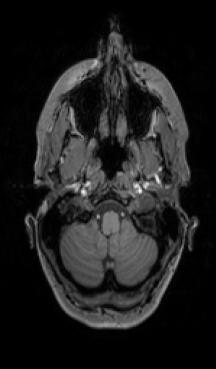

In [5]:
img

In [6]:
x.shape

(369, 216, 3)

## 1.1 Dataframe creation with images paths and label



In [7]:
def path_df(tr_path):
    classes = []
    class_paths = []

    for label in os.listdir(tr_path):
        folder = os.path.join(tr_path, label)
        if os.path.isdir(folder):
            for image in os.listdir(folder):
                classes.append(label)
                class_paths.append(os.path.join(folder, image))

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df


In [8]:
training_df = path_df(training_data_dir)

In [9]:
training_df


,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,glioma
1,/home/aurore/code/afallo/brain_tumor_detection...,glioma
2,/home/aurore/code/afallo/brain_tumor_detection...,glioma
3,/home/aurore/code/afallo/brain_tumor_detection...,glioma
4,/home/aurore/code/afallo/brain_tumor_detection...,glioma
...,...,...
11405,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11406,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11407,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11408,/home/aurore/code/afallo/brain_tumor_detection...,notumor


In [10]:
testing_df = path_df(testing_data_dir)

In [11]:
def label(x):
    if x=="glioma"or x=="meningioma" or x=="pituitary" :
        x = "tumor"
    return x

In [12]:
training_df["Class"] = training_df["Class"].apply(label)
training_df

,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,tumor
1,/home/aurore/code/afallo/brain_tumor_detection...,tumor
2,/home/aurore/code/afallo/brain_tumor_detection...,tumor
3,/home/aurore/code/afallo/brain_tumor_detection...,tumor
4,/home/aurore/code/afallo/brain_tumor_detection...,tumor
...,...,...
11405,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11406,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11407,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11408,/home/aurore/code/afallo/brain_tumor_detection...,notumor


In [13]:
testing_df["Class"] = testing_df["Class"].apply(label)
testing_df

,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,tumor
1,/home/aurore/code/afallo/brain_tumor_detection...,tumor
2,/home/aurore/code/afallo/brain_tumor_detection...,tumor
3,/home/aurore/code/afallo/brain_tumor_detection...,tumor
4,/home/aurore/code/afallo/brain_tumor_detection...,tumor
...,...,...
2492,/home/aurore/code/afallo/brain_tumor_detection...,notumor
2493,/home/aurore/code/afallo/brain_tumor_detection...,notumor
2494,/home/aurore/code/afallo/brain_tumor_detection...,notumor
2495,/home/aurore/code/afallo/brain_tumor_detection...,notumor


# 2.Train val test split

In [14]:
val_df, train_df = train_test_split(training_df, train_size=0.3, stratify=training_df['Class'])

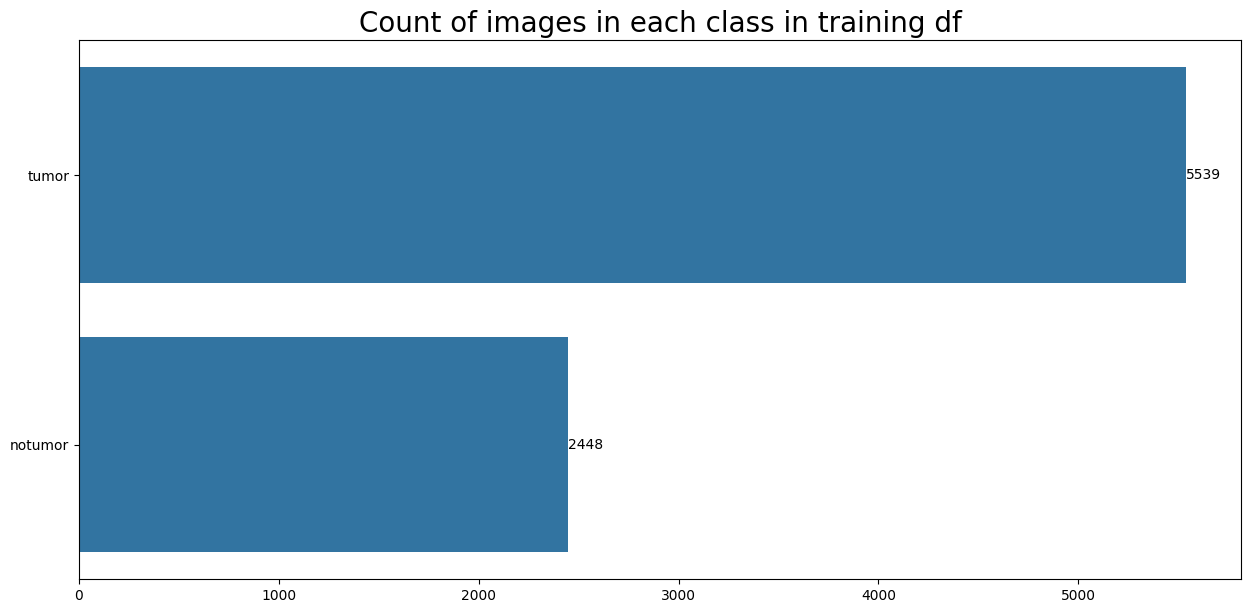

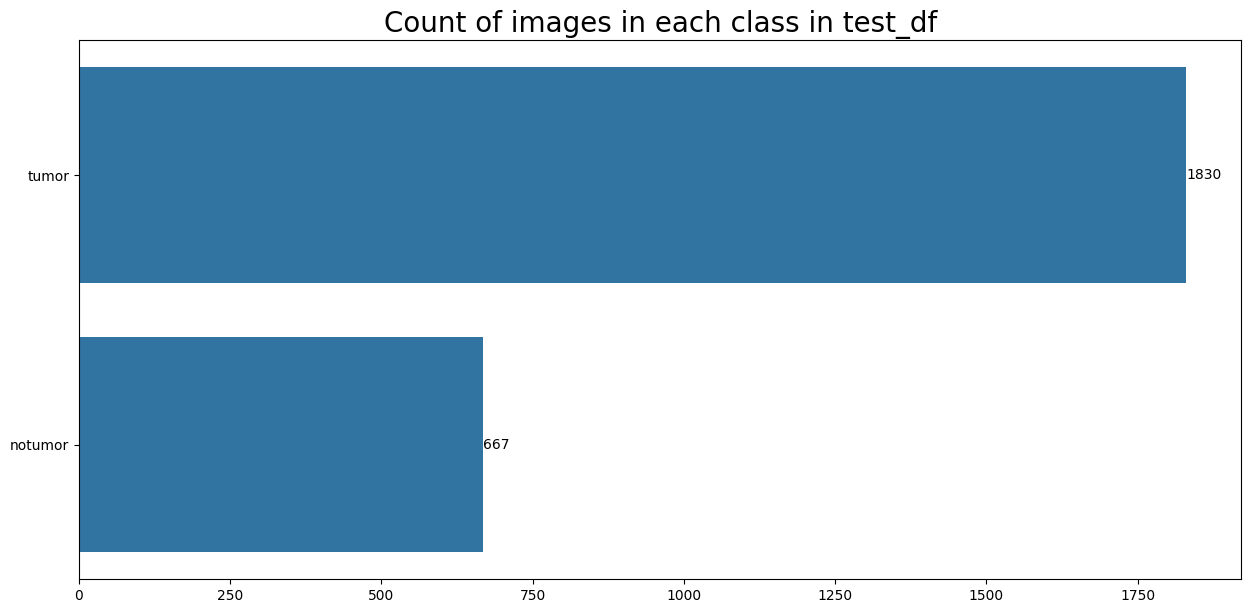

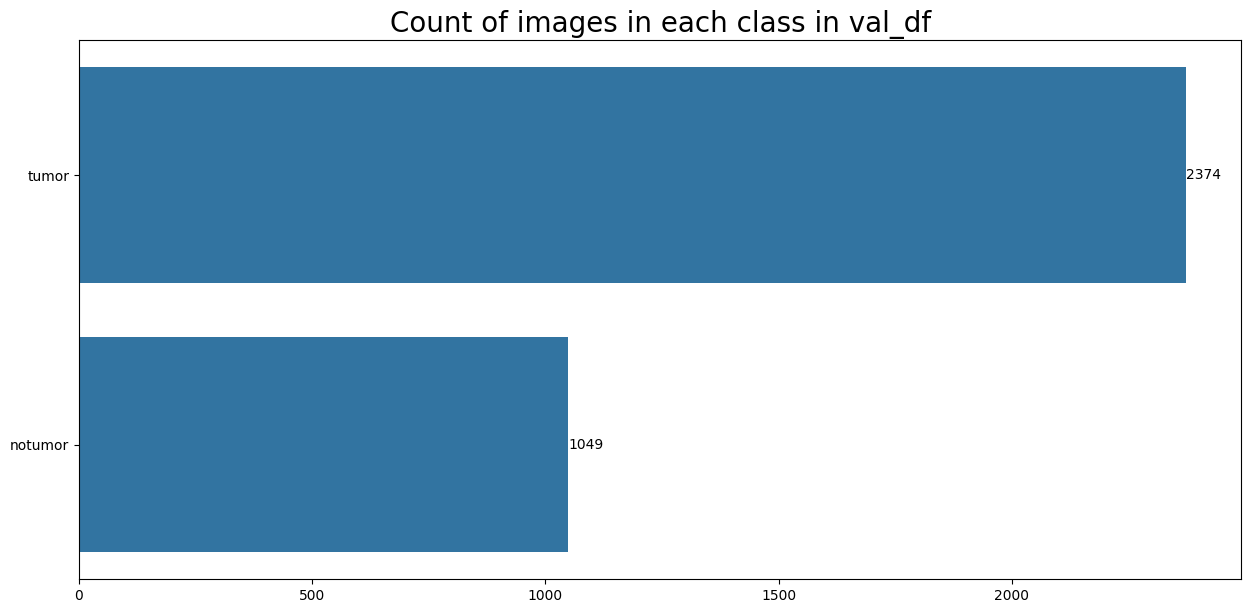

In [15]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in training df', fontsize=20)
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,7))
ax = sns.countplot(data=testing_df , y=testing_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in test_df', fontsize=20)
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,7))
ax = sns.countplot(data=val_df , y=val_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in val_df', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

# 3.Preprocess

In [16]:
batch_size = 32
img_size = (128, 128)

scale = ImageDataGenerator(rescale=1/255)
scale_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")


val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")

test_scale = scale.flow_from_dataframe(testing_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary", shuffle = False)

Found 7987 validated image filenames belonging to 2 classes.
Found 7987 validated image filenames belonging to 2 classes.
Found 3423 validated image filenames belonging to 2 classes.
Found 3423 validated image filenames belonging to 2 classes.
Found 2495 validated image filenames belonging to 2 classes.


/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


In [17]:
len(train_df)

7987

# 4.Base Model

In [18]:
def initialize_model():

    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32, (4, 4), padding ='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3, 3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(32, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(1, activation='sigmoid'))

    ### Model compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Recall(), Precision()])
    return model

In [19]:
model = initialize_model()
model.summary()

2025-12-02 16:37:08.538480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-12-02 16:37:08.538613: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-02 16:37:08.538654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2025-12-02 16:37:08.539164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                                 
 dense (Dense)               (None, 32)                4

In [20]:
es = EarlyStopping(patience = 5, restore_best_weights=True )
history = model.fit(train_scale,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

Epoch 1/20
250/250 [==============================] - 16s 61ms/step - loss: 0.3348 - accuracy: 0.8608 - recall: 0.9280 - precision: 0.8782 - val_loss: 0.1965 - val_accuracy: 0.9273 - val_recall: 0.9334 - val_precision: 0.9606
Epoch 2/20
250/250 [==============================] - 12s 50ms/step - loss: 0.1649 - accuracy: 0.9419 - recall: 0.9639 - precision: 0.9529 - val_loss: 0.1481 - val_accuracy: 0.9498 - val_recall: 0.9819 - val_precision: 0.9476
Epoch 3/20
250/250 [==============================] - 14s 55ms/step - loss: 0.0956 - accuracy: 0.9681 - recall: 0.9787 - precision: 0.9754 - val_loss: 0.1183 - val_accuracy: 0.9638 - val_recall: 0.9823 - val_precision: 0.9660
Epoch 4/20
250/250 [==============================] - 12s 49ms/step - loss: 0.0623 - accuracy: 0.9771 - recall: 0.9848 - precision: 0.9822 - val_loss: 0.1075 - val_accuracy: 0.9699 - val_recall: 0.9844 - val_precision: 0.9725
Epoch 5/20
250/250 [==============================] - 13s 53ms/step - loss: 0.0346 - accuracy: 0

In [23]:
def plot_history(history):

    fig, ax = plt.subplots(4, 1, figsize=(8,13))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")


    ax[2].set_title('Recall')

    ax[2].plot(history.epoch, history.history["recall"], label="Train recall")
    ax[2].plot(history.epoch, history.history["val_recall"], label="Validation recall")

    ax[3].set_title('Precision')

    ax[3].plot(history.epoch, history.history["precision"], label="precision")
    ax[3].plot(history.epoch, history.history["val_precision"], label="Validation precision")


    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

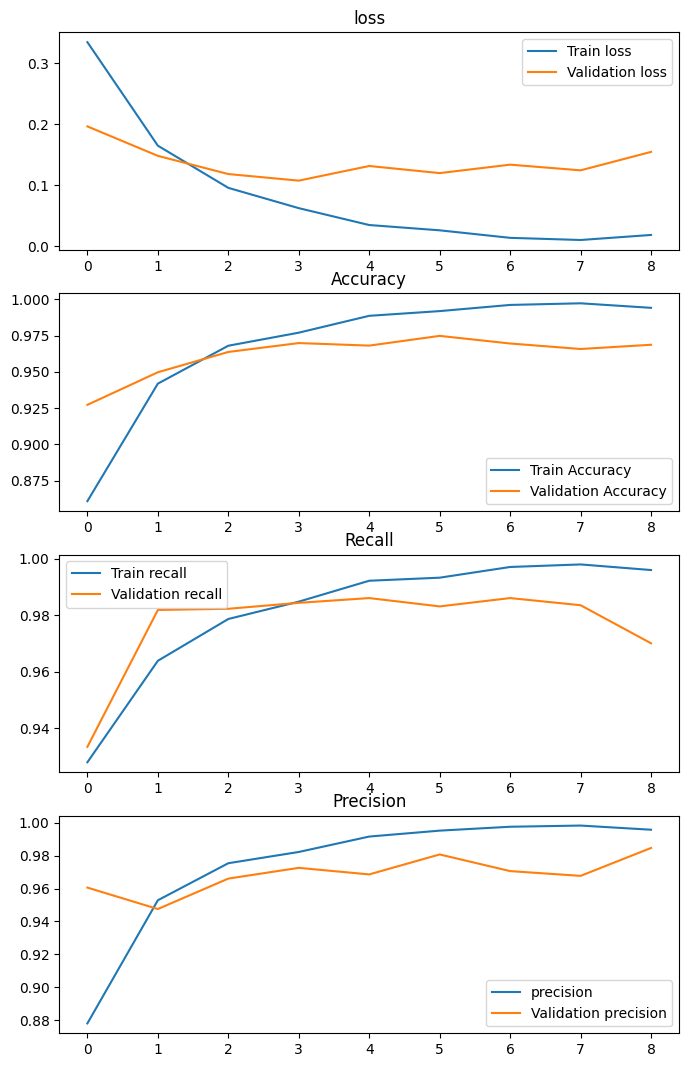

In [24]:

plot_history(history)


In [25]:
model.evaluate(test_scale)

78/78 [==============================] - 2s 27ms/step - loss: 0.1245 - accuracy: 0.9667 - recall: 0.9617 - precision: 0.9927


[0.1245393380522728, 0.966733455657959, 0.9617486596107483, 0.9926677942276001]

In [26]:
predictions = model.predict(test_scale, steps=len(test_scale))

78/78 [==============================] - 2s 24ms/step


In [27]:
y_pred = (predictions > 0.5).astype(int).ravel()


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_scale.classes, y_pred)


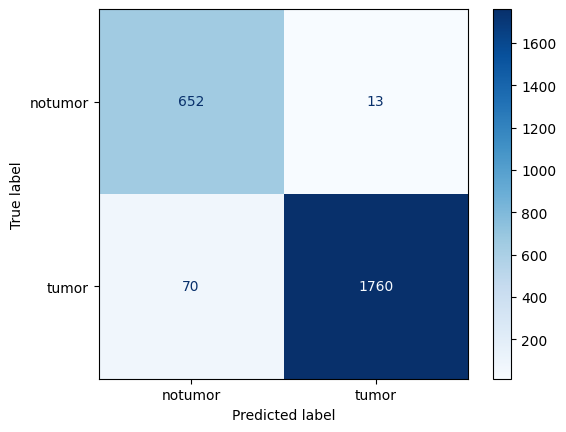

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_scale.class_indices.keys())
disp.plot(cmap='Blues')


In [30]:
predictions

array([[9.9958163e-01],
       [9.9988550e-01],
       [9.9852210e-01],
       ...,
       [1.0824245e-03],
       [8.2780018e-02],
       [5.8425387e-04]], dtype=float32)

In [37]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

skf.get_n_splits(training_df, training_df['Class'])



results = []
es = EarlyStopping(patience = 5, restore_best_weights=True )

for train_index, test_index in skf.split(training_df, training_df['Class']):
#     # Split the data into train and test

    train_df, val_df = training_df.iloc[train_index], training_df.iloc[test_index]

#     # Scaling your data


    train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

    train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

    val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, class_mode="binary")


    val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, class_mode="binary")


    # 3. Model
    model = initialize_model()
    history = model.fit(train_scale,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

    # 4. Evaluation

    results.append(model.evaluate(val_scale))

Found 9128 validated image filenames belonging to 2 classes.
Found 9128 validated image filenames belonging to 2 classes.
Found 2282 validated image filenames belonging to 2 classes.
Found 2282 validated image filenames belonging to 2 classes.
Epoch 1/20
286/286 [==============================] - 14s 48ms/step - loss: 0.3181 - accuracy: 0.8717 - recall_1: 0.9305 - precision_1: 0.8896 - val_loss: 0.2587 - val_accuracy: 0.9014 - val_recall_1: 0.9665 - val_precision_1: 0.8989
Epoch 2/20
286/286 [==============================] - 15s 51ms/step - loss: 0.1607 - accuracy: 0.9419 - recall_1: 0.9611 - precision_1: 0.9554 - val_loss: 0.1677 - val_accuracy: 0.9378 - val_recall_1: 0.9286 - val_precision_1: 0.9807
Epoch 3/20
286/286 [==============================] - 14s 47ms/step - loss: 0.1063 - accuracy: 0.9641 - recall_1: 0.9766 - precision_1: 0.9717 - val_loss: 0.1222 - val_accuracy: 0.9636 - val_recall_1: 0.9722 - val_precision_1: 0.9753
Epoch 4/20
286/286 [==============================] - 

In [46]:
results

[[0.10014554858207703,
  0.9684487581253052,
  0.9696778059005737,
  0.9846054911613464],
 [0.09823315590620041,
  0.9745836853981018,
  0.9823120832443237,
  0.9810725450515747],
 [0.09870567917823792,
  0.9745836853981018,
  0.9842072129249573,
  0.9792582988739014],
 [0.08031488955020905,
  0.9719544053077698,
  0.9797724485397339,
  0.9797724485397339],
 [0.09186454117298126,
  0.9785276055335999,
  0.982300877571106,
  0.9866666793823242]]

In [55]:
results

[[0.10014554858207703,
  0.9684487581253052,
  0.9696778059005737,
  0.9846054911613464],
 [0.09823315590620041,
  0.9745836853981018,
  0.9823120832443237,
  0.9810725450515747],
 [0.09870567917823792,
  0.9745836853981018,
  0.9842072129249573,
  0.9792582988739014],
 [0.08031488955020905,
  0.9719544053077698,
  0.9797724485397339,
  0.9797724485397339],
 [0.09186454117298126,
  0.9785276055335999,
  0.982300877571106,
  0.9866666793823242]]

In [57]:
accuracy = np.mean([sublist[1] for sublist in results])
accuracy

0.9736196279525757

In [59]:
recall = np.mean([sublist[2] for sublist in results])
recall

0.9796540856361389

In [58]:
precision = np.mean([sublist[3] for sublist in results])
precision

0.9822750926017761

In [ ]:
model = initialize_model()

train_scale_total = scale.flow_from_dataframe(training_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

model.fit(train_scale_total,
                 epochs=20,
                 callbacks = [es])


Found 11410 validated image filenames belonging to 2 classes.
Epoch 1/20
357/357 [==============================] - 17s 47ms/step - loss: 0.4123 - accuracy: 0.8192 - recall_6: 0.9521 - precision_6: 0.8173
Epoch 2/20
357/357 [==============================] - 16s 45ms/step - loss: 0.2742 - accuracy: 0.9219 - recall_6: 0.9388 - precision_6: 0.9481
Epoch 3/20
357/357 [==============================] - 16s 45ms/step - loss: 0.2269 - accuracy: 0.9395 - recall_6: 0.9454 - precision_6: 0.9667
Epoch 4/20
357/357 [==============================] - 18s 51ms/step - loss: 0.1828 - accuracy: 0.9549 - recall_6: 0.9584 - precision_6: 0.9761
Epoch 5/20
357/357 [==============================] - 17s 48ms/step - loss: 0.1449 - accuracy: 0.9664 - recall_6: 0.9682 - precision_6: 0.9832
Epoch 6/20
357/357 [==============================] - 16s 44ms/step - loss: 0.1215 - accuracy: 0.9730 - recall_6: 0.9716 - precision_6: 0.9893
Epoch 7/20
357/357 [==============================] - 17s 47ms/step - loss: 0.10

In [61]:
predictions = model.predict(test_scale, steps=len(test_scale))
y_pred = (predictions > 0.5).astype(int).ravel()
cm = confusion_matrix(test_scale.classes, y_pred)

78/78 [==============================] - 2s 27ms/step


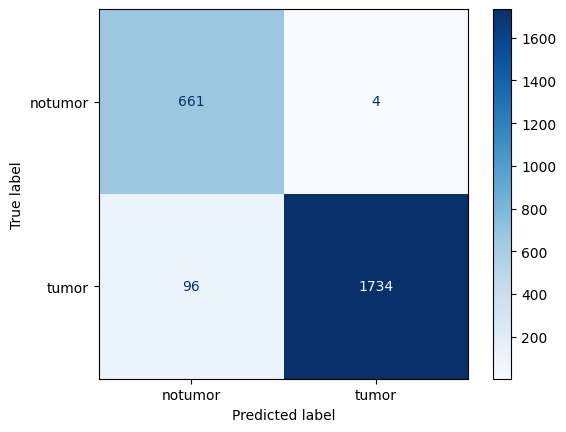

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_scale.class_indices.keys())
disp.plot(cmap='Blues')

In [63]:
model.evaluate(test_scale)

78/78 [==============================] - 2s 27ms/step - loss: 0.1267 - accuracy: 0.9599 - recall_6: 0.9475 - precision_6: 0.9977


[0.1266854703426361, 0.959919810295105, 0.9475409984588623, 0.9976984858512878]